# Цель лабораторной работы
Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей<cite data-cite="ue:lab4"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab4"></cite>:

1. Выбрать набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости провести удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода `train_test_split` разделить выборку на обучающую и тестовую.
4. Обучить модель ближайших соседей для произвольно заданного гиперпараметра $K$. Оценить качество модели с помощью трех подходящих для задачи метрик.
5. Построить модель и оценить качество модели с использованием кросс-валидации. Провести эксперименты с тремя различными стратегиями кросс-валидации.
6. Произвести подбор гиперпараметра $K$ с использованием `GridSearchCV` и кросс-валидации.
7. Повторить пункт 4 для найденного оптимального значения гиперпараметра $K$. Сравнить качество полученной модели с качеством модели, полученной в пункте 4.
8. Построить кривые обучения и валидации.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в дальнейшем текст в отчёте влезал на А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В качестве набора данных используются цены поддержанных машин в Индии<cite data-cite="kg:ucpi"></cite>:

In [3]:
data = pd.read_csv("./used_cars.csv")

Посмотрим на типы данных:

In [4]:
data.dtypes

Index                  int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                float64
Seats                float64
New_Price             object
Price                float64
dtype: object

In [5]:
data.head(10)

,Index,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74
5,5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.10,814.0,55.20,5.0,NaN,2.35
6,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,NaN,3.50
7,7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36,2755.0,171.50,8.0,21,17.50
8,8,Volkswagen Vento Diesel Comfortline,Pune,2013,64430,Diesel,Manual,First,20.54,1598.0,103.60,5.0,NaN,5.20
9,9,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.30,1248.0,74.00,5.0,NaN,1.95


Удалим ненужные столбцы:

In [6]:
data = data.drop(["Index", "Name", "Location", "New_Price"], axis=1)

Выполним кодирование категориальных признаков:

In [7]:
le = LabelEncoder()
data[["Fuel_Type"]] = le.fit_transform(
    data[["Fuel_Type"]].values.ravel())

data[["Transmission"]] = le.fit_transform(
    data[["Transmission"]].values.ravel())

data[["Owner_Type"]] = le.fit_transform(
    data[["Owner_Type"]].values.ravel())

Проверим данные на наличие пропусков:

In [8]:
data.isnull().sum()

Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
dtype: int64

Заполним пропуски медианным значением:

In [9]:
median_imp = SimpleImputer(strategy="median") 
data[["Mileage"]] =  median_imp.fit_transform(data[["Mileage"]])
data[["Engine"]] = median_imp.fit_transform(data[["Engine"]])
data[["Power"]] = median_imp.fit_transform(data[["Power"]])
data[["Seats"]] = median_imp.fit_transform(data[["Seats"]])

In [10]:
data.isnull().sum()

Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

Посмотрим на новые типы данных:

In [11]:
data.dtypes

Year                   int64
Kilometers_Driven      int64
Fuel_Type              int32
Transmission           int32
Owner_Type             int32
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price                float64
dtype: object

In [12]:
data.head(10)

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,2010,72000,0,1,0,26.60,998.0,58.16,5.0,1.75
1,2015,41000,1,1,0,19.67,1582.0,126.20,5.0,12.50
2,2011,46000,4,1,0,18.20,1199.0,88.70,5.0,4.50
3,2012,87000,1,1,0,20.77,1248.0,88.76,7.0,6.00
4,2013,40670,1,0,2,15.20,1968.0,140.80,5.0,17.74
5,2012,75000,3,1,0,21.10,814.0,55.20,5.0,2.35
6,2013,86999,1,1,0,23.08,1461.0,63.10,5.0,3.50
7,2016,36000,1,0,0,11.36,2755.0,171.50,8.0,17.50
8,2013,64430,1,1,0,20.54,1598.0,103.60,5.0,5.20
9,2012,65932,1,1,2,22.30,1248.0,74.00,5.0,1.95


In [13]:
data.shape

(6019, 10)

In [14]:
data.describe()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
count,6019.000000,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000
mean,2013.358199,5.873838e+04,2.363017,0.714238,0.379465,18.134966,1620.509221,112.883539,5.276790,9.479468
std,3.269742,9.126884e+04,1.504939,0.451814,0.818458,4.581528,599.635458,53.283701,0.806346,11.187917
min,1998.000000,1.710000e+02,0.000000,0.000000,0.000000,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,1.000000,0.000000,0.000000,15.170000,1198.000000,78.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,1.000000,1.000000,0.000000,18.150000,1493.000000,97.700000,5.000000,5.640000
75%,2016.000000,7.300000e+04,4.000000,1.000000,0.000000,21.100000,1969.000000,138.030000,5.000000,9.950000
max,2019.000000,6.500000e+06,4.000000,1.000000,3.000000,33.540000,5998.000000,560.000000,10.000000,160.000000


## Разделение данных
Разделим данные на целевой столбец и признаки:

In [15]:
x = data.drop("Price", axis=1)
y = data["Price"]

In [16]:
x.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,2010,72000,0,1,0,26.60,998.0,58.16,5.0
1,2015,41000,1,1,0,19.67,1582.0,126.20,5.0
2,2011,46000,4,1,0,18.20,1199.0,88.70,5.0
3,2012,87000,1,1,0,20.77,1248.0,88.76,7.0
4,2013,40670,1,0,2,15.20,1968.0,140.80,5.0


In [17]:
y.head()

0     1.75
1    12.50
2     4.50
3     6.00
4    17.74
Name: Price, dtype: float64

Обработаем данные, чтобы модель была более точной:

In [18]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

Разделим выборку на обучающую и тестовую:

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.25,
                                                    random_state=77)

In [20]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4514, 9) (1505, 9) (4514,) (1505,)


## Модель ближайших соседей для произвольно заданного гиперпараметра $K$

Попробуем метод ближайших соседей с гиперпараметром $K=5$ (значение по умолчанию):

In [21]:
reg_5 = KNeighborsRegressor(n_neighbors=5)
reg_5.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

Оценим качество модели с помощью трех подходящих для задачи метрик:

In [22]:
print("r2_score:", r2_score(y_test, reg_5.predict(x_test)))
print("mean_squared_error:",
      mean_squared_error(y_test, reg_5.predict(x_test)))
print("median_absolute_error:",
      median_absolute_error(y_test, reg_5.predict(x_test)))

r2_score: 0.8282092476938556
mean_squared_error: 21.224948560797344
median_absolute_error: 0.8140000000000001


## Кросс-валидация

Применим стратегию K-fold:

In [23]:
scores = cross_val_score(reg_5, x, y, cv=KFold(n_splits=5))
print("Accuracy: %0.2f (± %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (± 0.05)


Применим стратегию Repeated K-fold:

In [24]:
scores = cross_val_score(reg_5, x, y, cv=RepeatedKFold(n_splits=2,
                                                       n_repeats=2,
                                                       random_state=77))
print("Accuracy: %0.2f (± %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (± 0.01)


Применим стратегию Shuffle & Split:

In [25]:
scores = cross_val_score(reg_5, x, y, cv=ShuffleSplit(n_splits=5,
                                                      test_size=0.25,
                                                      random_state=0))
print("Accuracy: %0.2f (± %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.84 (± 0.04)


## Подбор гиперпараметра $K$  с испльзованием GridSearchCV и кросс-валидации

In [26]:
grid_params = {'n_neighbors': [3,5,7,9,11,13,15,17,19,21]}
gs = GridSearchCV(KNeighborsRegressor(), grid_params,
                  cv=KFold(n_splits=5), n_jobs=-1)
gs.fit(x, y)
gs.best_params_

{'n_neighbors': 7}

Сравним качество полученной модели с качеством модели, полученной ранее:

In [27]:
reg_gs = KNeighborsRegressor(n_neighbors=gs.best_params_['n_neighbors'])
reg_gs.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

In [28]:
print("r2_score:", r2_score(y_test, reg_gs.predict(x_test)))
print("mean_squared_error:",
      mean_squared_error(y_test, reg_gs.predict(x_test)))
print("median_absolute_error:",
      median_absolute_error(y_test, reg_gs.predict(x_test)))

r2_score: 0.8283642934556125
mean_squared_error: 21.205792475422065
median_absolute_error: 0.8385714285714281


Значения показателей метрик оказались немного лучше предыдущих значений.

Построим кривую обучения<cite data-cite="doc:sklearn"></cite>:

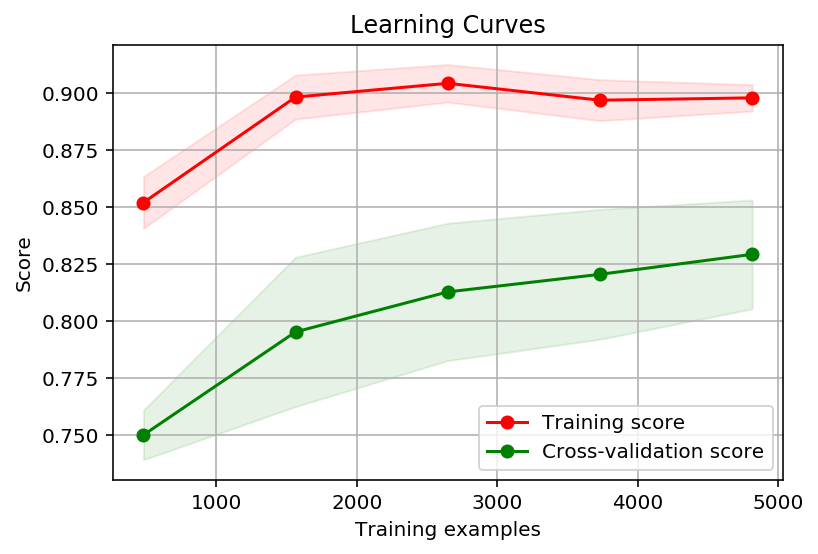

In [29]:
train_sizes = np.linspace(.1, 1.0, 5)

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")

train_sizes, train_scores, test_scores = learning_curve(
    KNeighborsRegressor(), x, y, cv=KFold(n_splits=5), n_jobs=-1,
    train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score");
plt.legend(loc="best");

Построим кривую валидации:

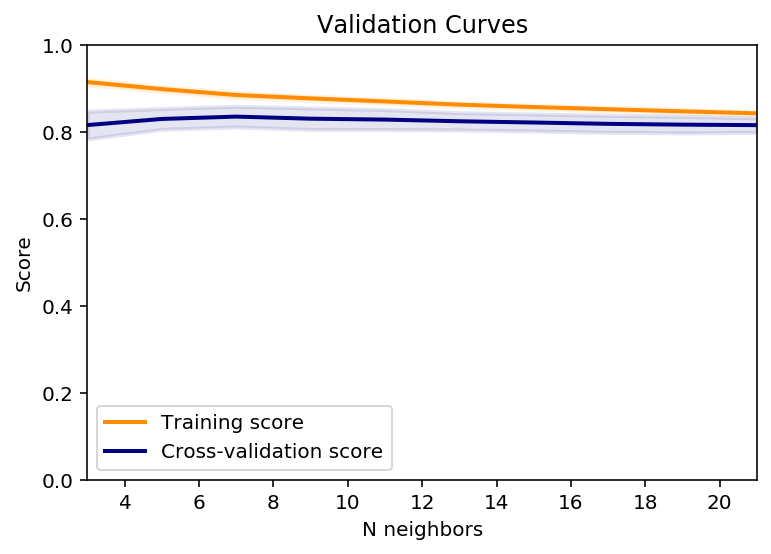

In [30]:
param_range = [3,5,7,9,11,13,15,17,19,21]

train_scores, test_scores = validation_curve(
    KNeighborsRegressor(), x, y, param_name="n_neighbors",
    param_range=param_range,
    scoring="r2",
    n_jobs=-1,
    cv=KFold(n_splits=5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curves")
plt.xlabel("N neighbors")
plt.ylabel("Score")
plt.xlim(3.0, 21.0)
plt.ylim(0.0, 1.0)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best");